In [1]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from graspy.cluster import AutoGMMCluster, GaussianCluster
from graspy.embed import AdjacencySpectralEmbed
from graspy.plot import pairplot
from graspy.utils import pass_to_ranks
from sklearn.metrics import adjusted_rand_score
from umap import UMAP

from src.data import load_metagraph
from src.io import savefig
from src.utils import get_paired_inds
from src.visualization import CLASS_COLOR_DICT, adjplot, stacked_barplot

os.chdir("/mnt/c/Users/t-bpedig/code/maggot/")

In [2]:

sns.set_context("talk")
# FNAME = os.path.basename(__file__)[:-3]
# print(FNAME)

np.random.seed(8888)


def stashfig(name, **kws):
    pass
    # savefig(name, foldername=FNAME, save_on=True, **kws)


def make_ellipses(gmm, ax, i, j, colors, alpha=0.5, equal=False, **kws):
    inds = [j, i]
    for n, color in enumerate(colors):
        if gmm.covariance_type == "full":
            covariances = gmm.covariances_[n][np.ix_(inds, inds)]
        elif gmm.covariance_type == "tied":
            covariances = gmm.covariances_[np.ix_(inds, inds)]
        elif gmm.covariance_type == "diag":
            covariances = np.diag(gmm.covariances_[n][inds])
        elif gmm.covariance_type == "spherical":
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        ell = mpl.patches.Ellipse(
            gmm.means_[n, inds], v[0], v[1], 180 + angle, color=color, **kws
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(alpha)
        ax.add_artist(ell)
        if equal:
            ax.set_aspect("equal", "datalim")


def cluster_pairplot(
    X,
    model,
    labels=None,
    label_palette=None,
    cluster_palette=None,
    upper_hue=None,
    lower_hue="clusters",
    upper_elipses="unfilled",
    lower_elipses="filled",
    equal=False,
    axs=None,
    linewidth=0,
    s=10,
    alpha=0.7,
):
    k = model.n_components
    if axs is not None:
        if axs.shape[0] != k or axs.shape[1] != k:
            raise ValueError()

    n_dims = X.shape[1]

    if upper_hue is None and labels is not None:
        upper_hue = "labels"

    if axs is None:
        fig, axs = plt.subplots(
            n_dims, n_dims, sharex=False, sharey=False, figsize=(20, 20)
        )

    pred = model.predict(X)

    data = pd.DataFrame(data=X)
    data["labels"] = labels
    data["clusters"] = pred

    palette_map = {"labels": label_palette, "clusters": cluster_palette}
    cluster_colors = list(map(cluster_palette.get, np.unique(pred)))

    for i in range(n_dims):
        for j in range(n_dims):
            ax = axs[i, j]
            # ax.axis("off")
            ax.set(xlabel="", ylabel="", xticks=[], yticks=[])
            ax.spines["right"].set_visible(False)
            ax.spines["top"].set_visible(False)

            if i < j:  # upper triangle
                sns.scatterplot(
                    data=data,
                    x=j,
                    y=i,
                    ax=ax,
                    alpha=alpha,
                    linewidth=linewidth,
                    s=s,
                    legend=False,
                    hue=upper_hue,
                    palette=palette_map[upper_hue],
                )
                if upper_elipses != False:
                    fill_val = upper_elipses == "filled"
                    make_ellipses(
                        model, ax, i, j, cluster_colors, fill=fill_val, equal=equal
                    )

            if i > j:  # lower triangle
                sns.scatterplot(
                    data=data,
                    x=j,
                    y=i,
                    ax=ax,
                    alpha=alpha,
                    linewidth=linewidth,
                    s=s,
                    legend=False,
                    hue=lower_hue,
                    palette=palette_map[lower_hue],
                )
                if lower_elipses != False:
                    fill_val = lower_elipses == "filled"
                    make_ellipses(
                        model, ax, i, j, cluster_colors, fill=fill_val, equal=equal
                    )

            if i == j:
                ax.axis("off")
                # sns.distplot(data[i], ax=ax, hue=upper_hue)

    plt.tight_layout()
    return fig, axs


# plotting settings
rc_dict = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.formatter.limits": (-3, 3),
    "figure.figsize": (6, 3),
    "figure.dpi": 100,
    "axes.edgecolor": "lightgrey",
    "ytick.color": "grey",
    "xtick.color": "grey",
    "axes.labelcolor": "dimgrey",
    "text.color": "dimgrey",
    "xtick.major.size": 0,
    "ytick.major.size": 0,
}
for key, val in rc_dict.items():
    mpl.rcParams[key] = val
context = sns.plotting_context(context="talk", font_scale=1, rc=rc_dict)
sns.set_context(context)

In [3]:

mg = load_metagraph("G")

class1_types = ["KC", "MBON", "MBIN", "uPN", "mPN", "vPN", "tPN", "APL"]  # no APL
class2_types = []

meta = mg.meta
mb_meta = meta[meta["class1"].isin(class1_types) | meta["class2"].isin(class2_types)]
mb_meta = mb_meta[~mb_meta["partially_differentiated"]]
mb_meta = mb_meta[mb_meta["hemisphere"].isin(["L", "R"])]
mb_mg = mg.reindex(mb_meta.index, use_ids=True, inplace=False)
mb_mg.calculate_degrees(inplace=True)
mb_mg.meta["Total edgesum"] = -mb_mg.meta["Total edgesum"]
sizes = mb_mg.meta.groupby("class1").size()
mb_mg.meta["class1_sizes"] = -mb_mg.meta["class1"].map(sizes)

n_left
163
n_right
158


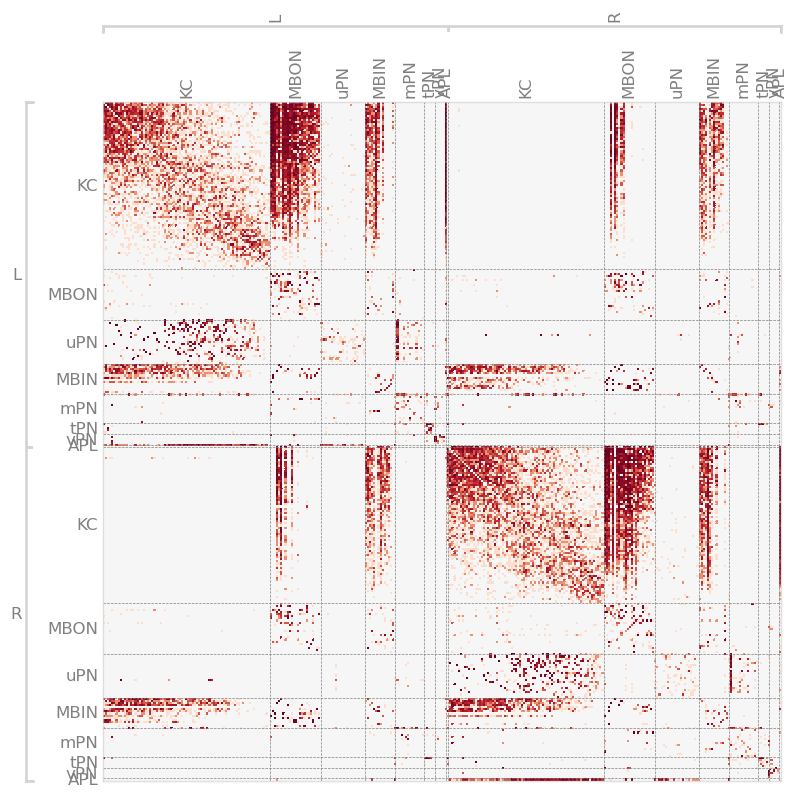

In [4]:

meta = mb_mg.meta
print("n_left")
print(len(meta[meta["left"]]))
print("n_right")
print(len(meta[meta["right"]]))

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
adjplot(
    pass_to_ranks(mb_mg.adj),
    meta=mb_mg.meta,
    sort_class=["hemisphere", "class1"],
    class_order=["class1_sizes"],
    item_order=["class1", "Total edgesum"],
    cbar=False,
    row_tick_pad=[0.05, 0.7],
    col_tick_pad=[0.2, 0.7],
    tick_rot=90,
    tick_fontsize=12,
    gridline_kws=dict(color="grey", linestyle="--", linewidth=0.5),
    ax=ax,
)

left_mb_mg = mb_mg.reindex(meta[meta["left"]].index, use_ids=True, inplace=False)
right_mb_mg = mb_mg.reindex(meta[meta["right"]].index, use_ids=True, inplace=False)

assert (
    np.unique(left_mb_mg.meta["pair_id"]) == np.unique(right_mb_mg.meta["pair_id"])
).all()

In [5]:

meta = mb_mg.meta
meta["inds"] = range(len(meta))
left_inds, right_inds = get_paired_inds(meta)
left_adj = mb_mg.adj[np.ix_(left_inds, left_inds)]
right_adj = mb_mg.adj[np.ix_(right_inds, right_inds)]

left



right


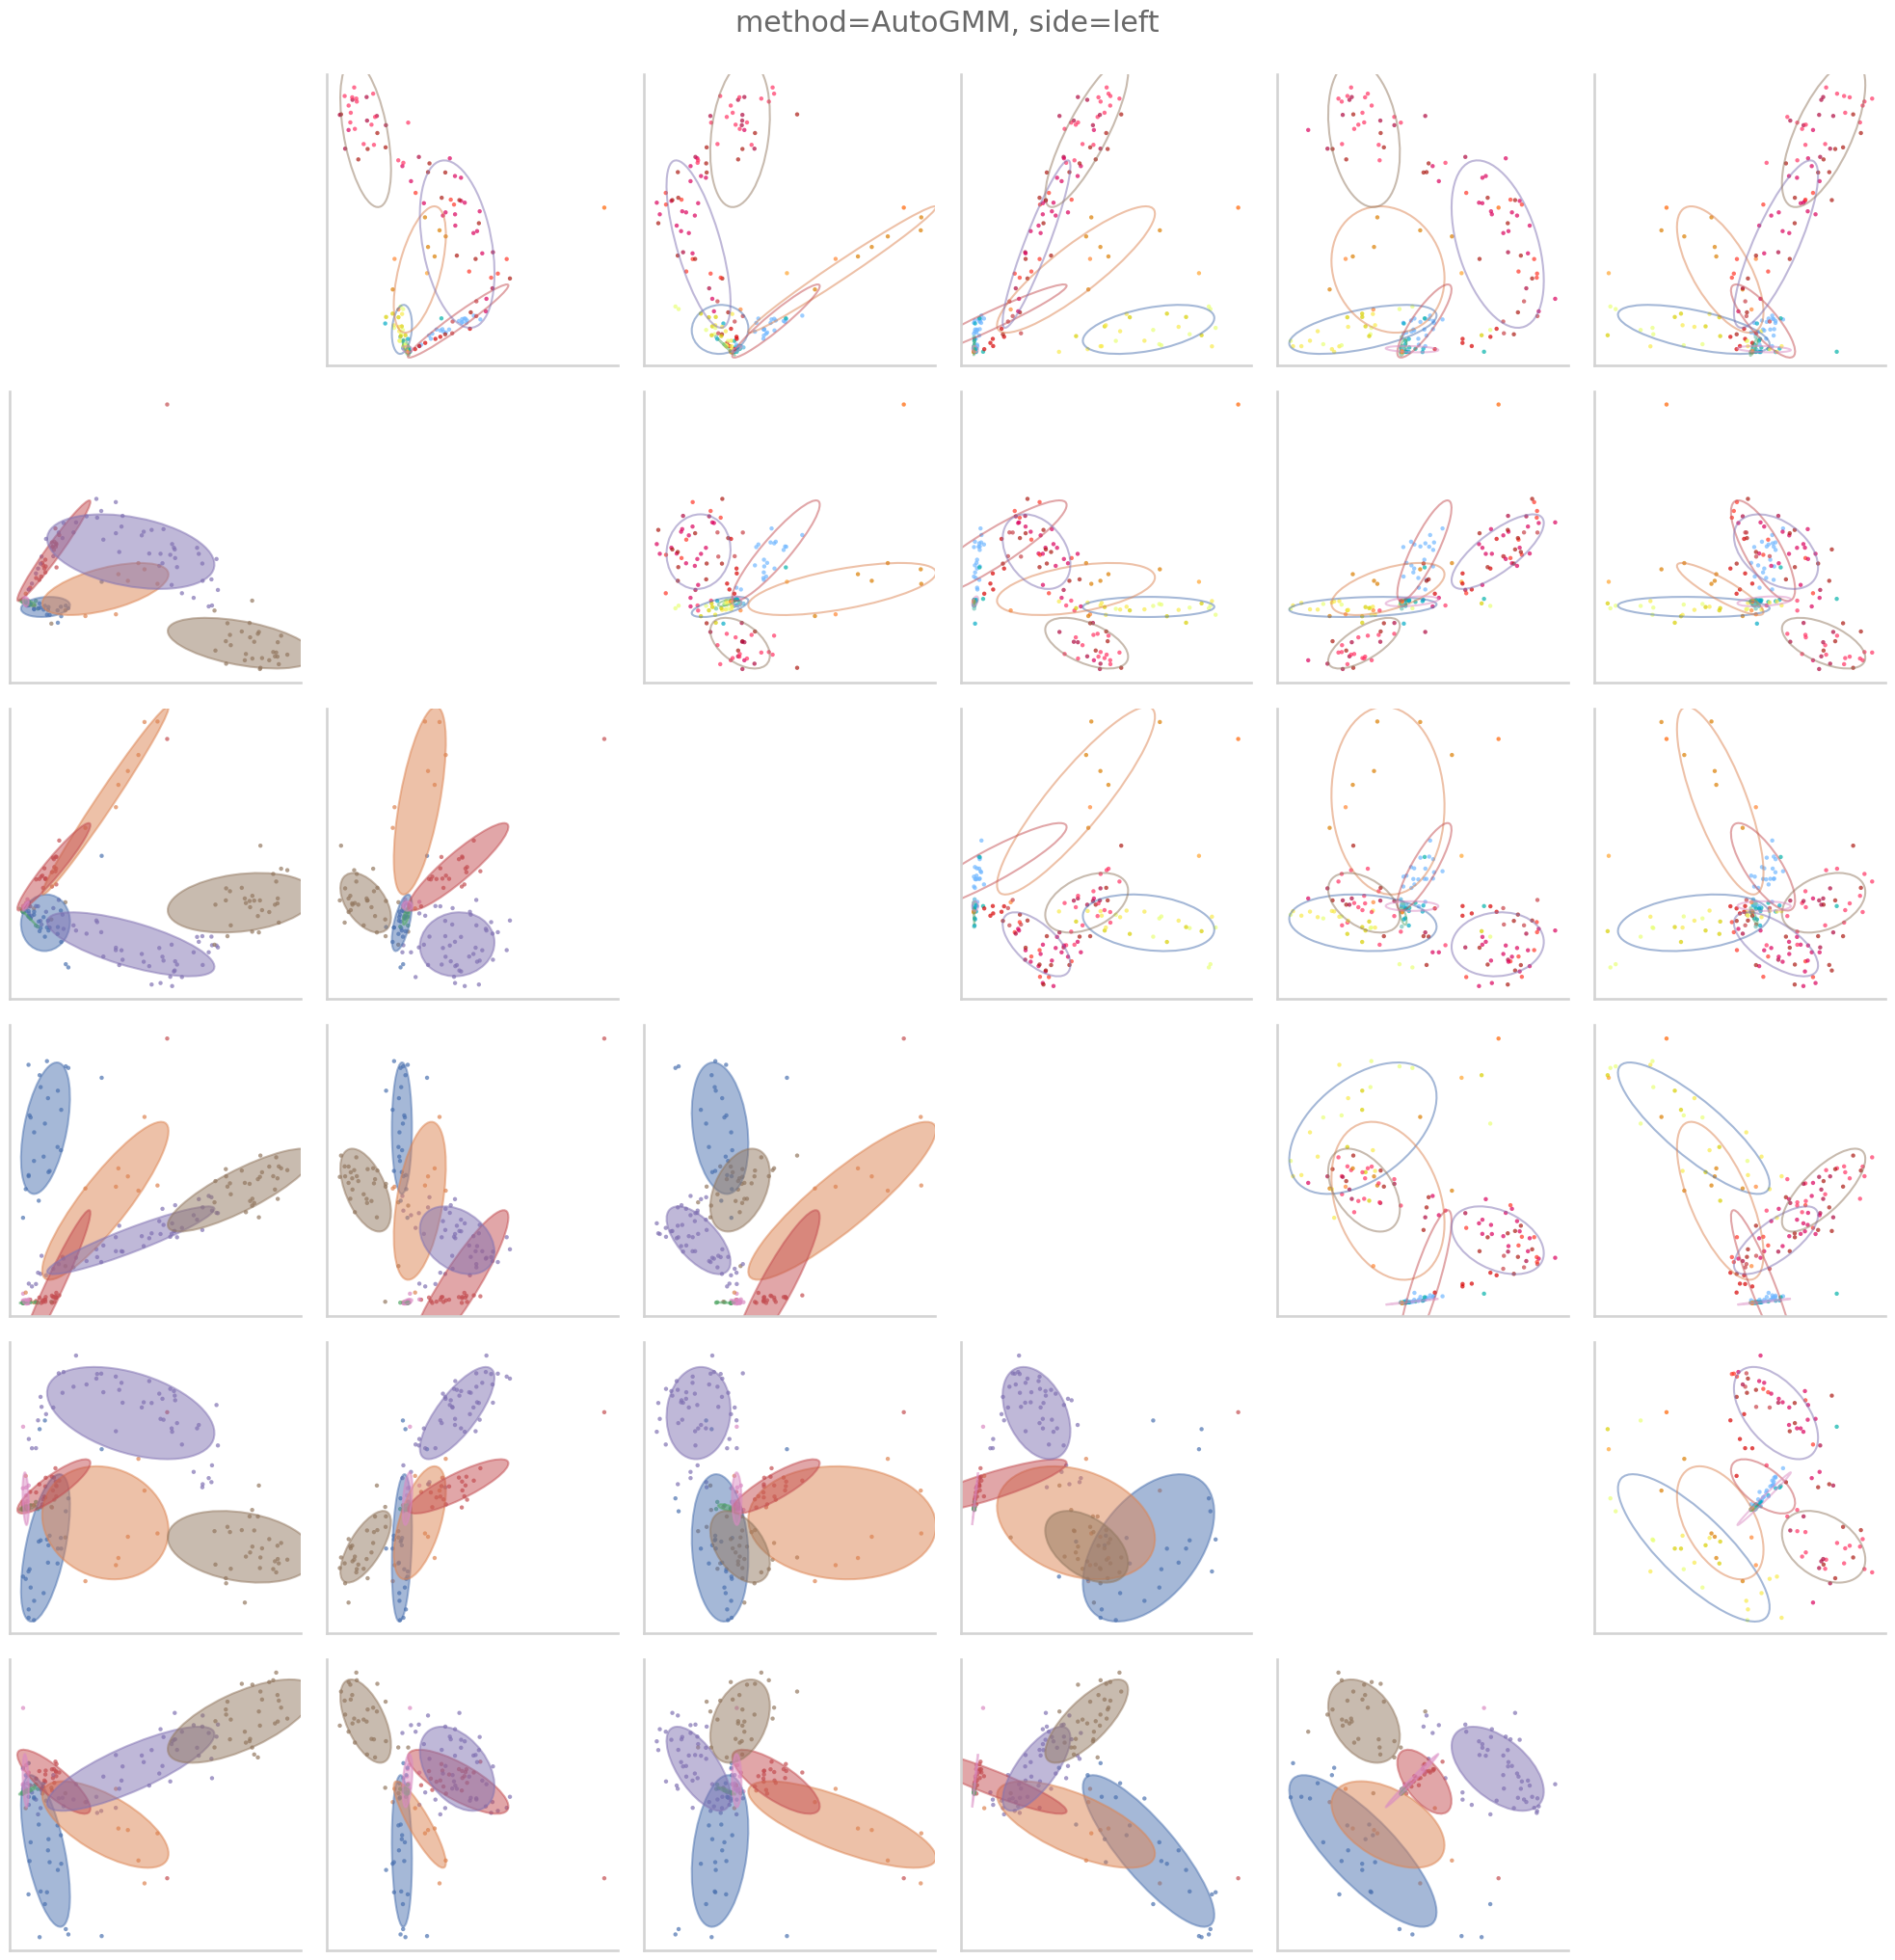

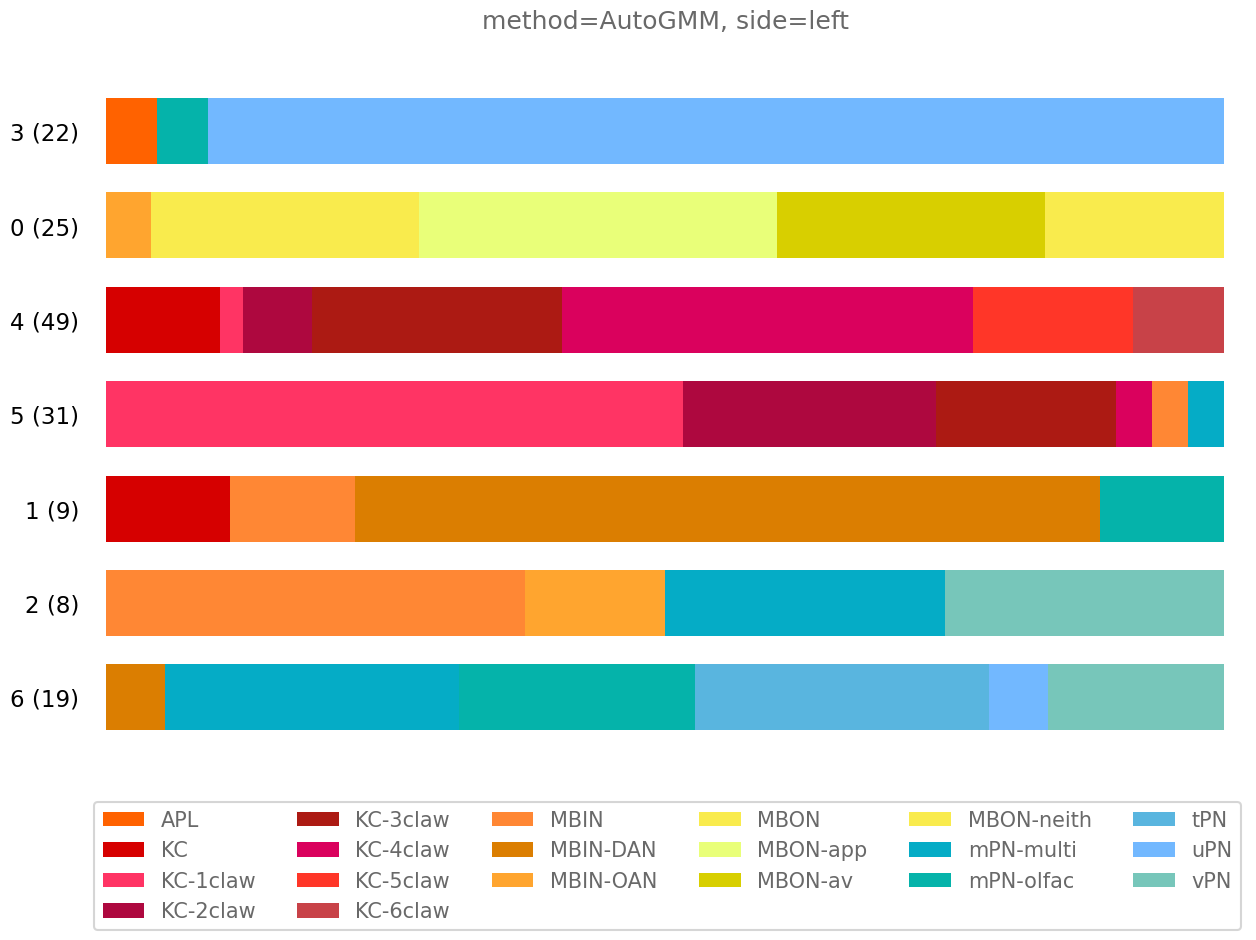

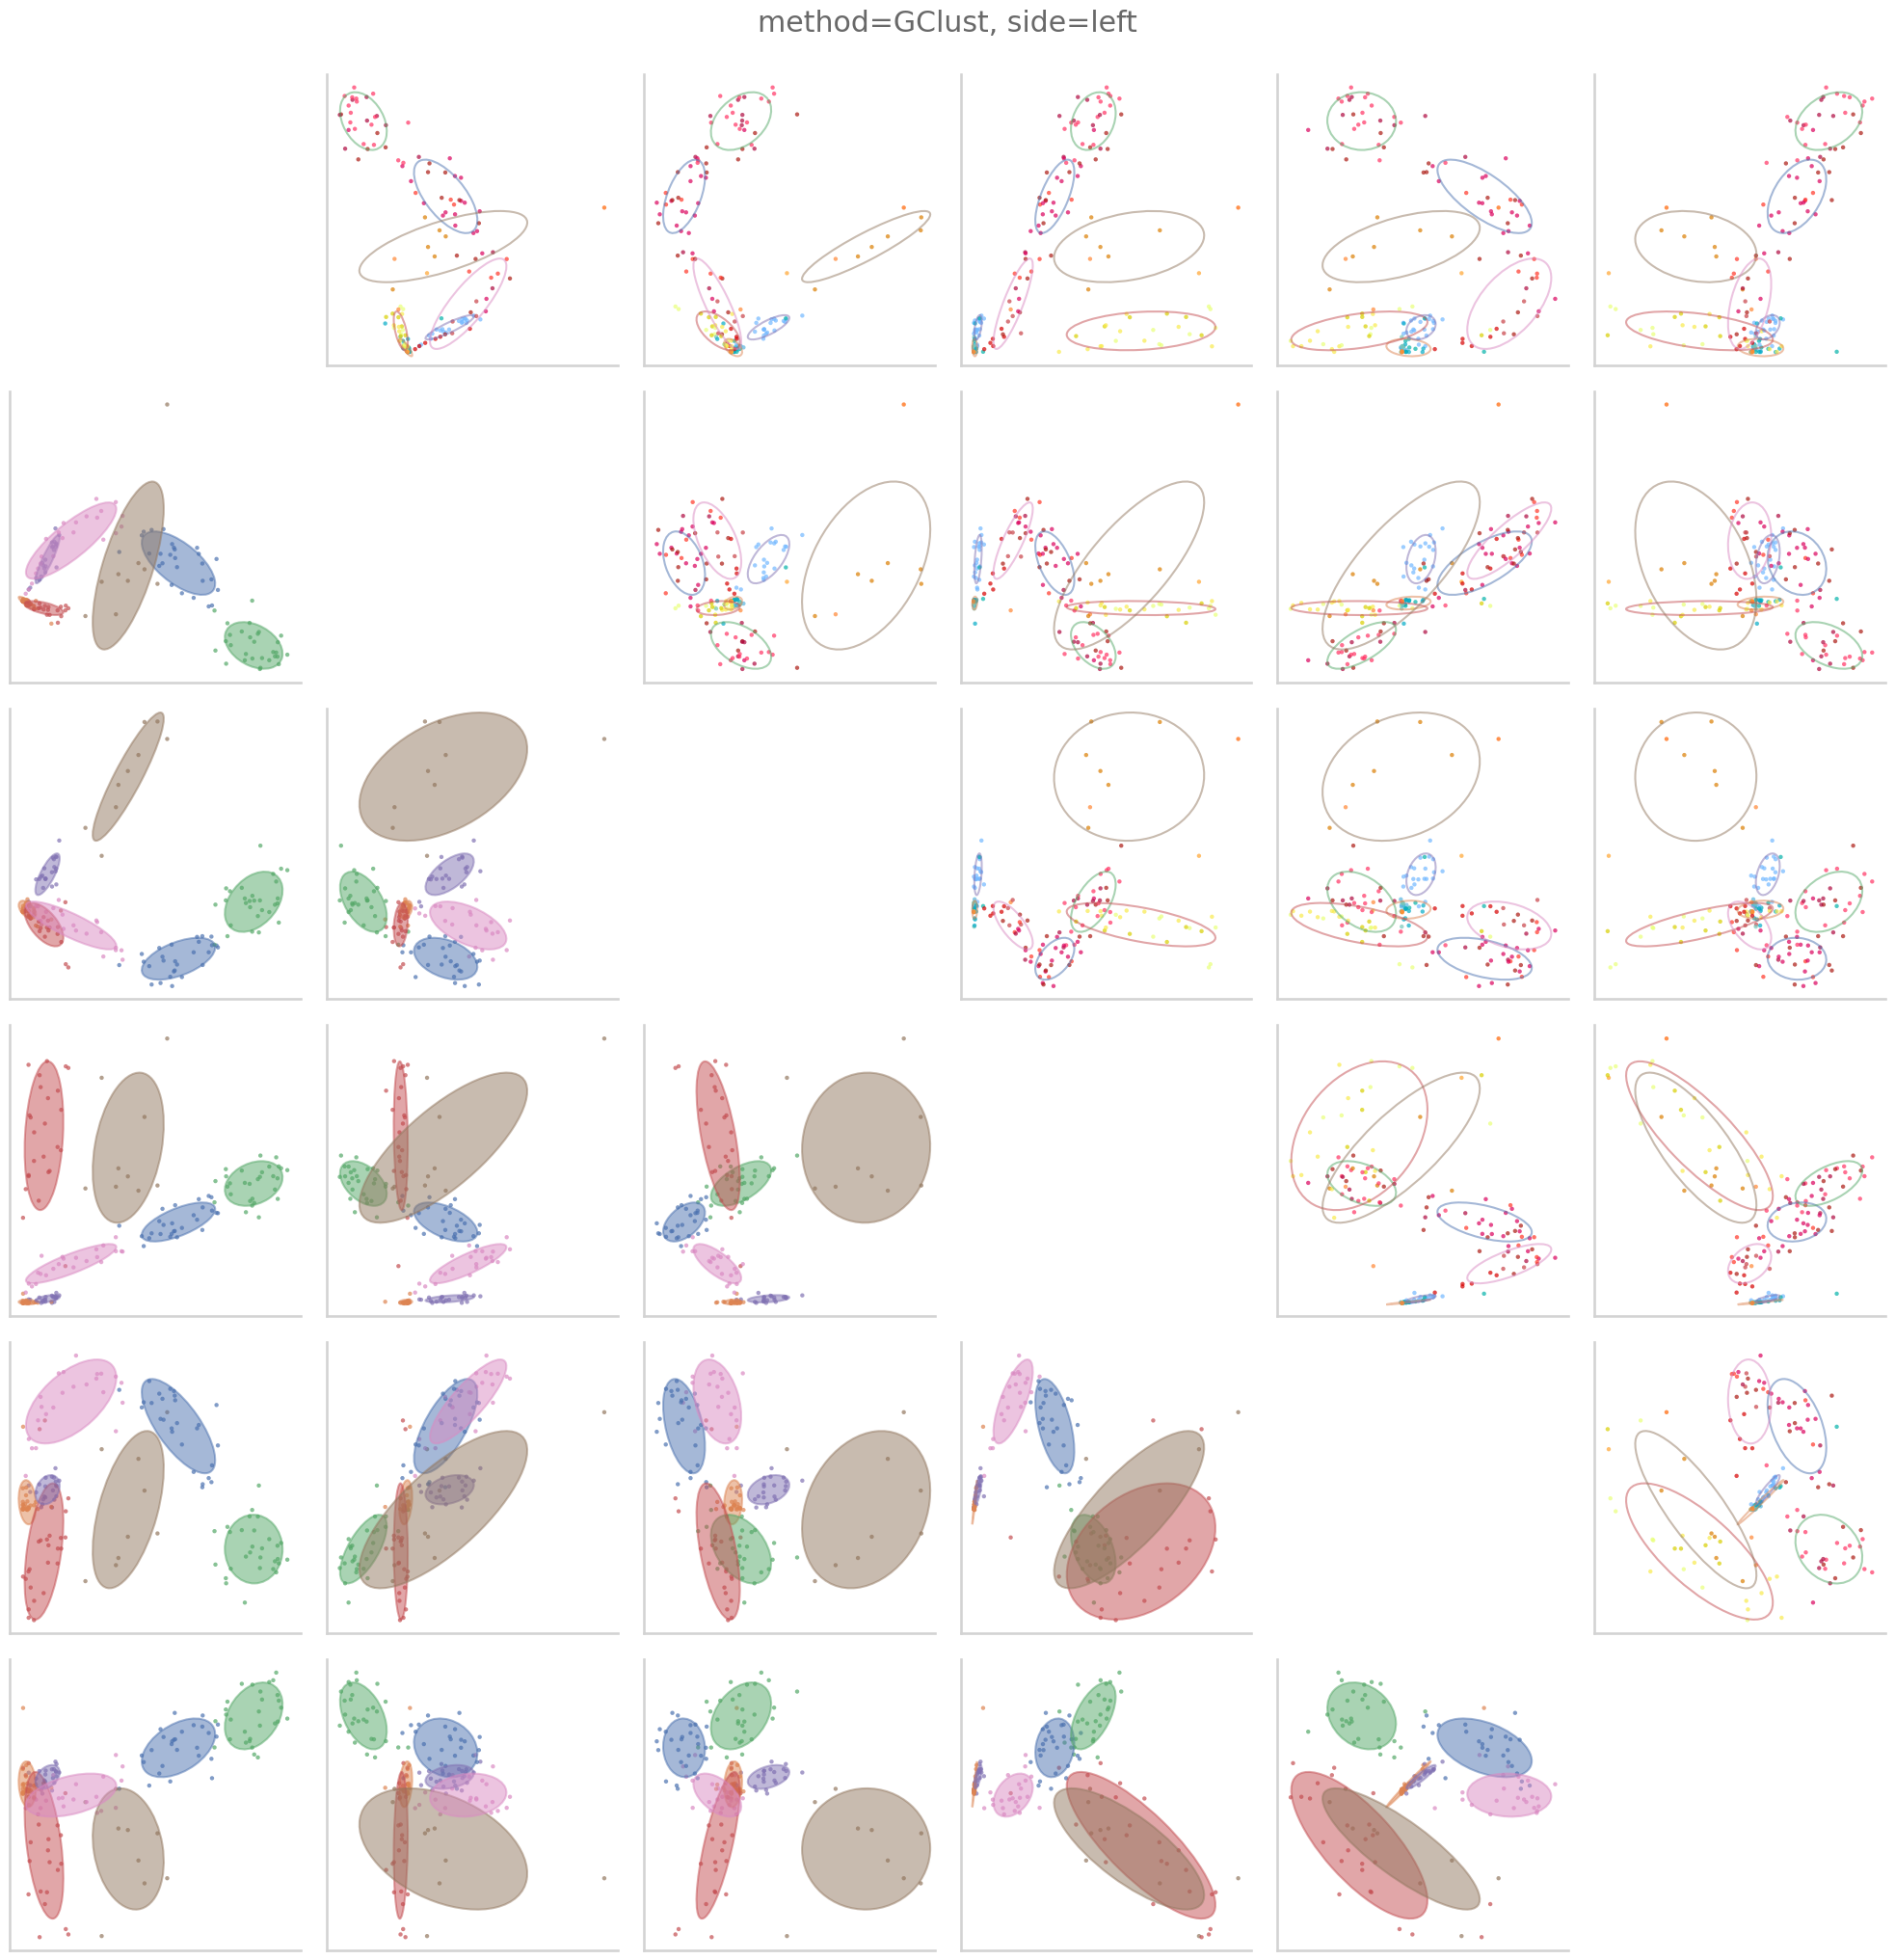

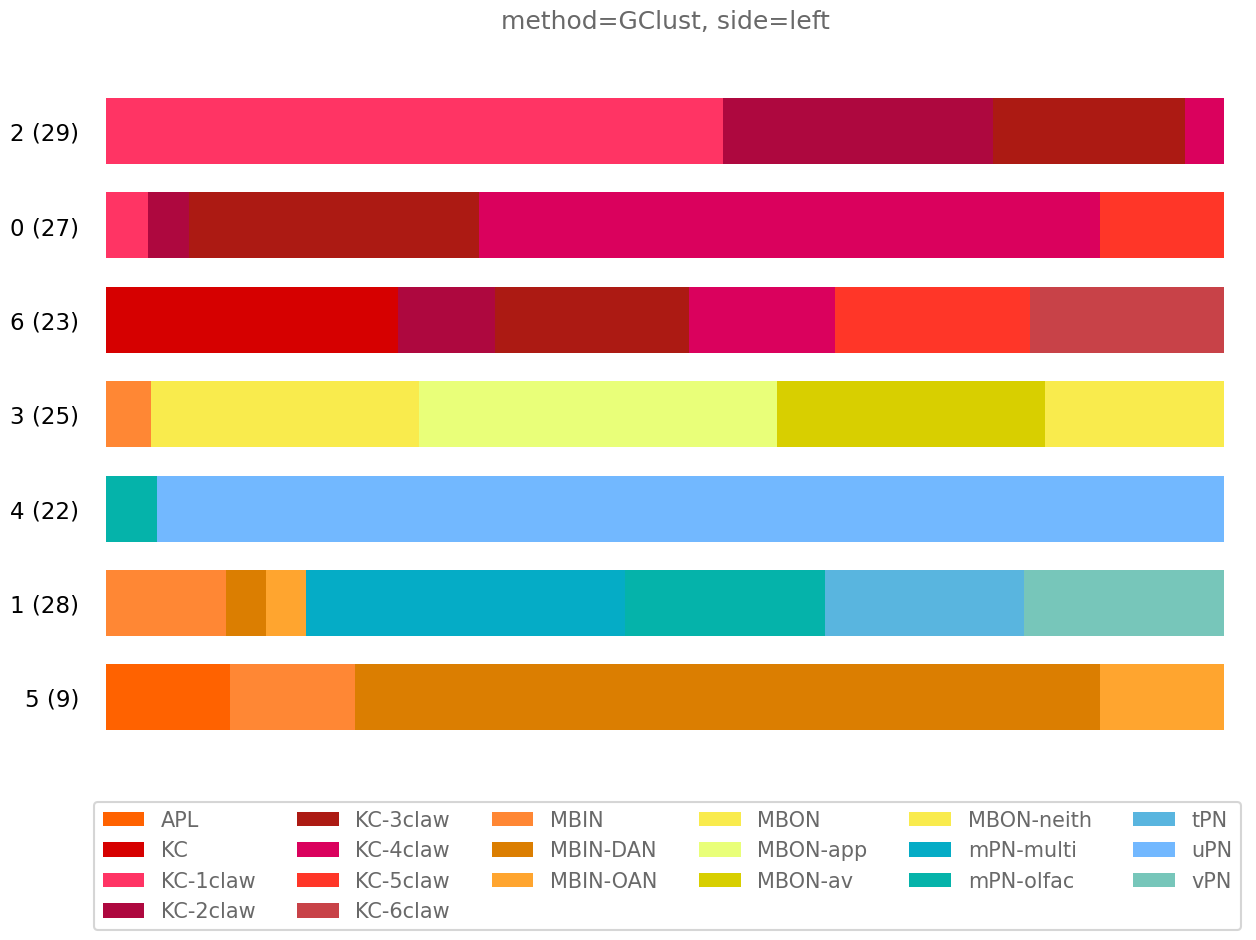

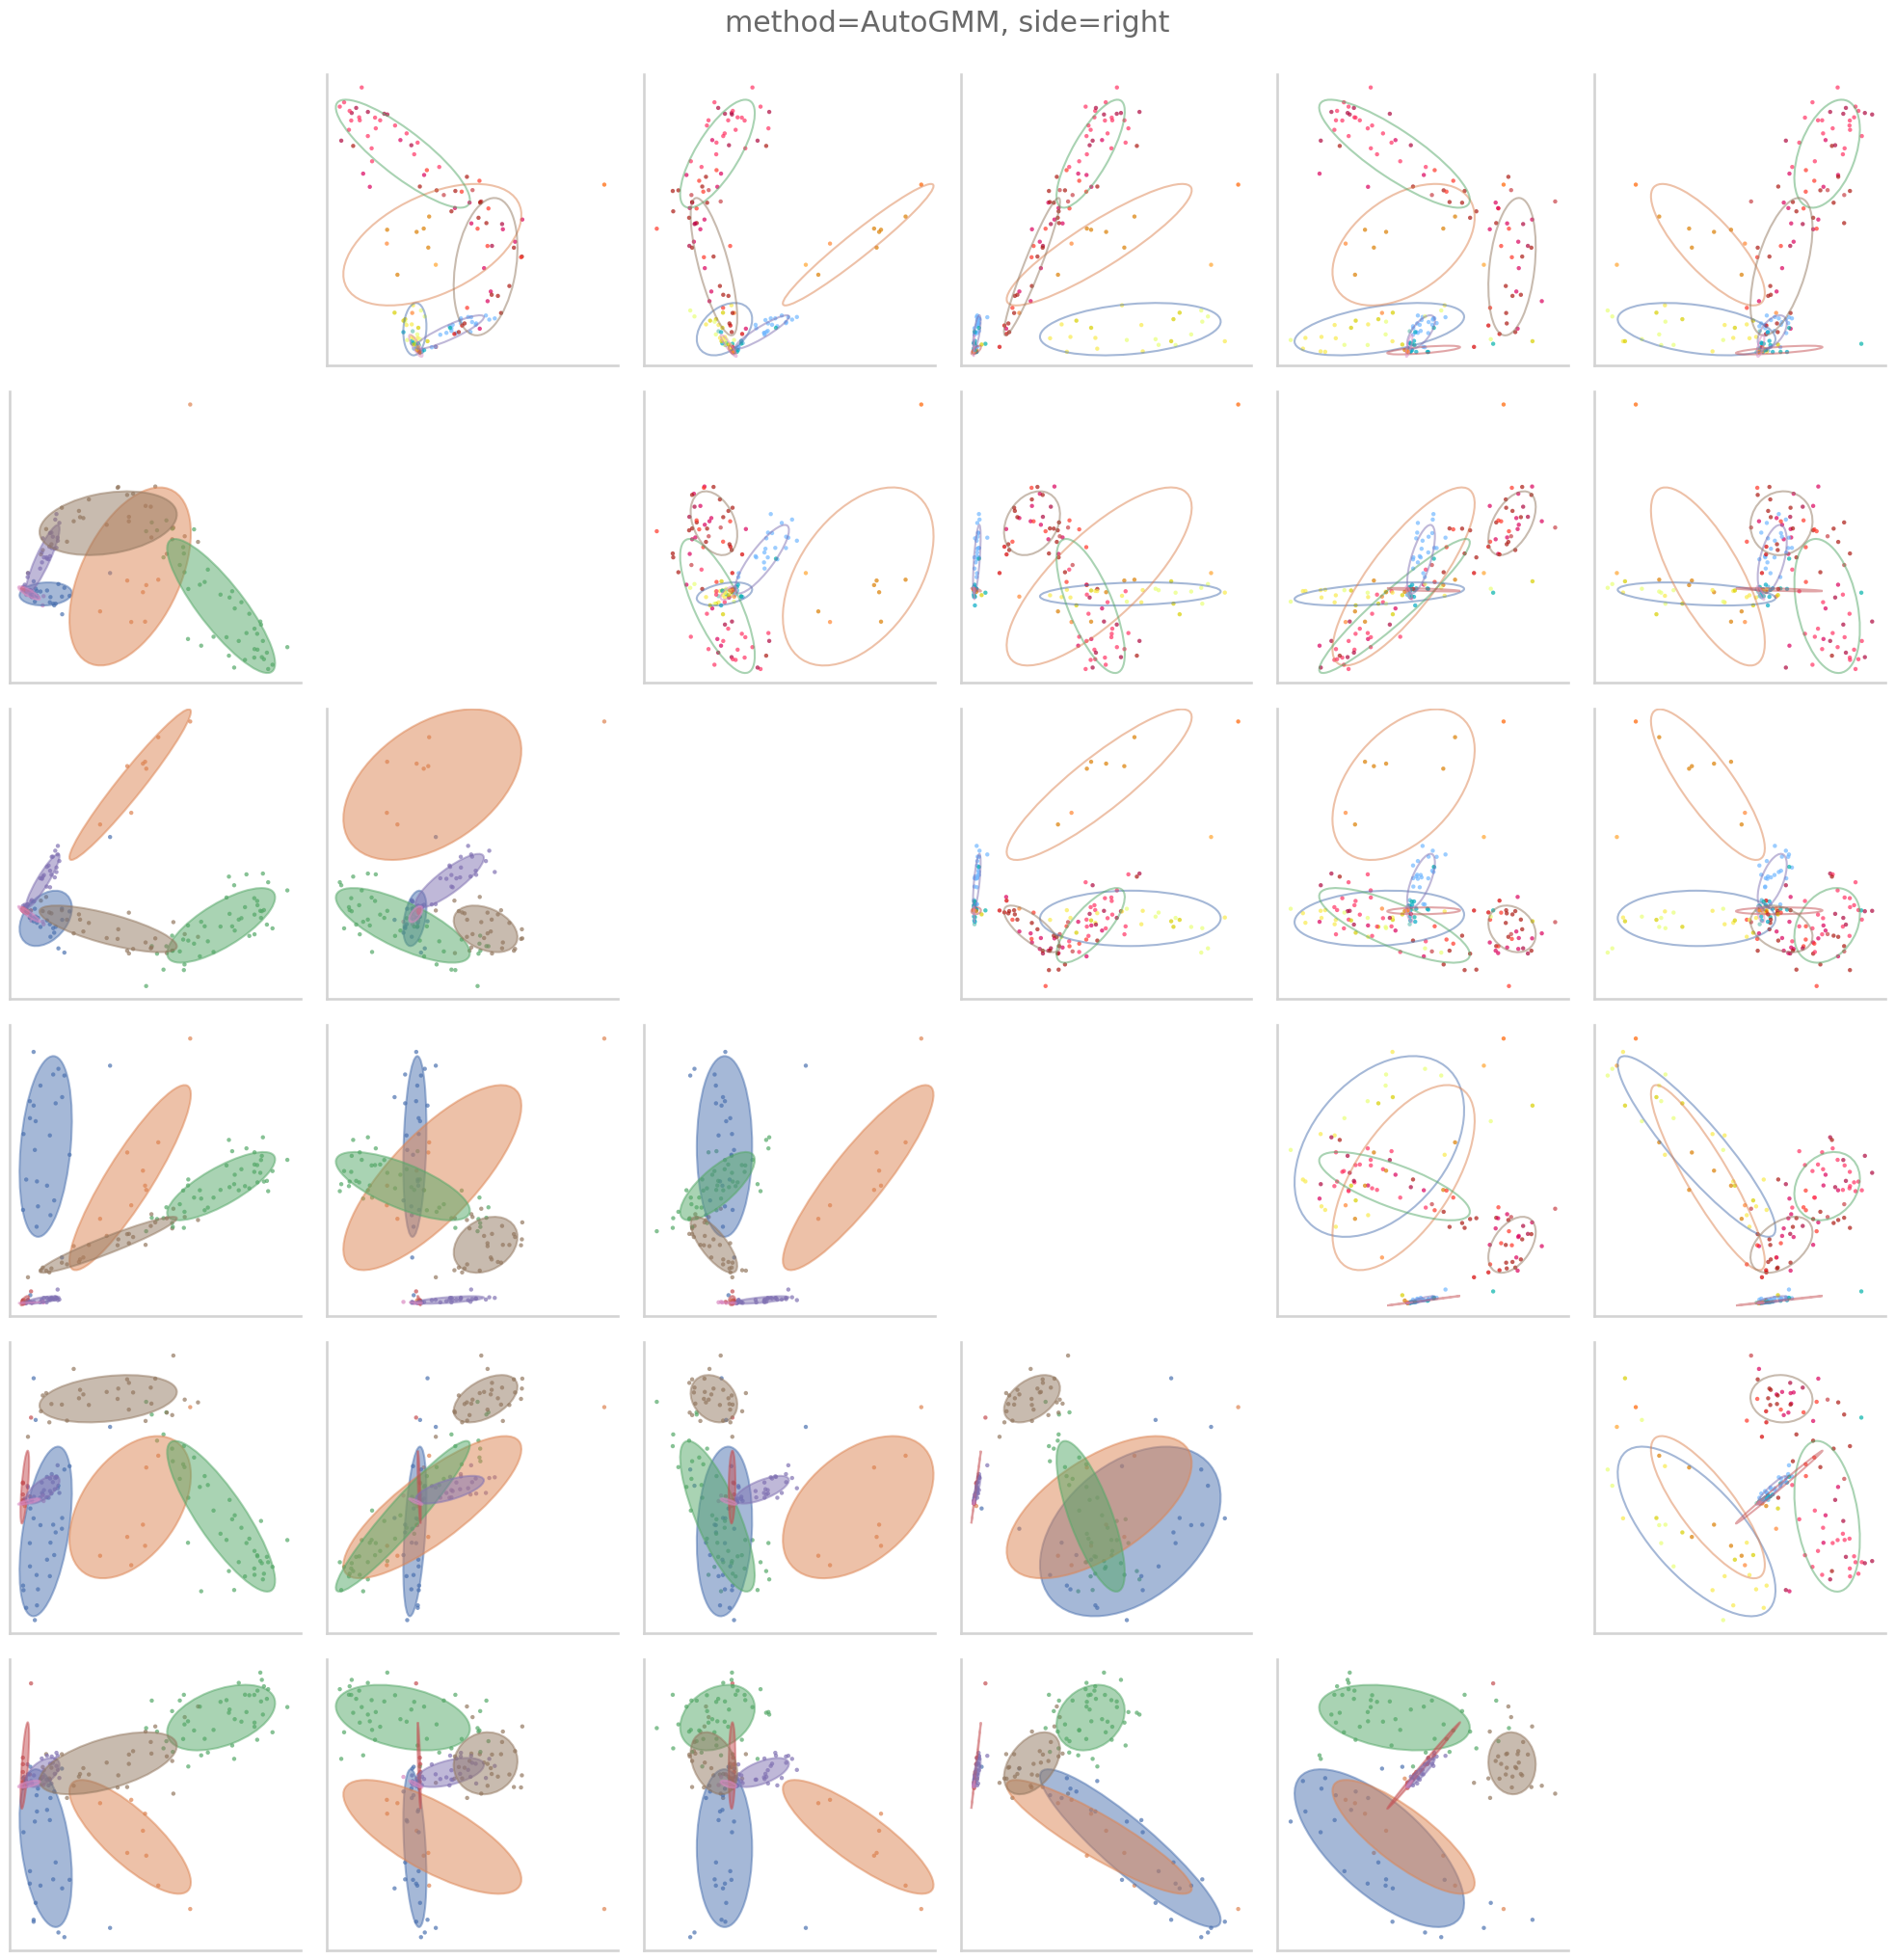

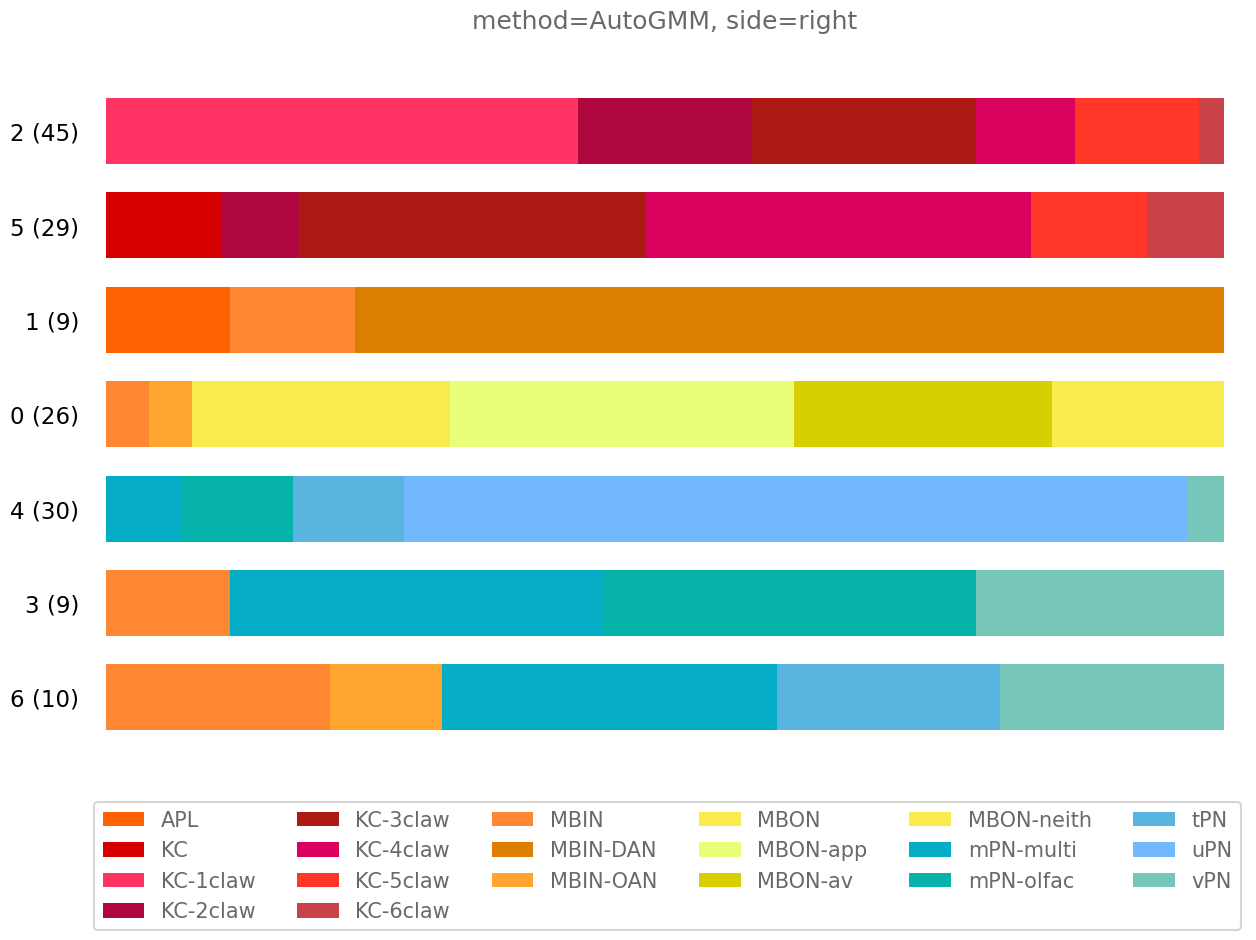

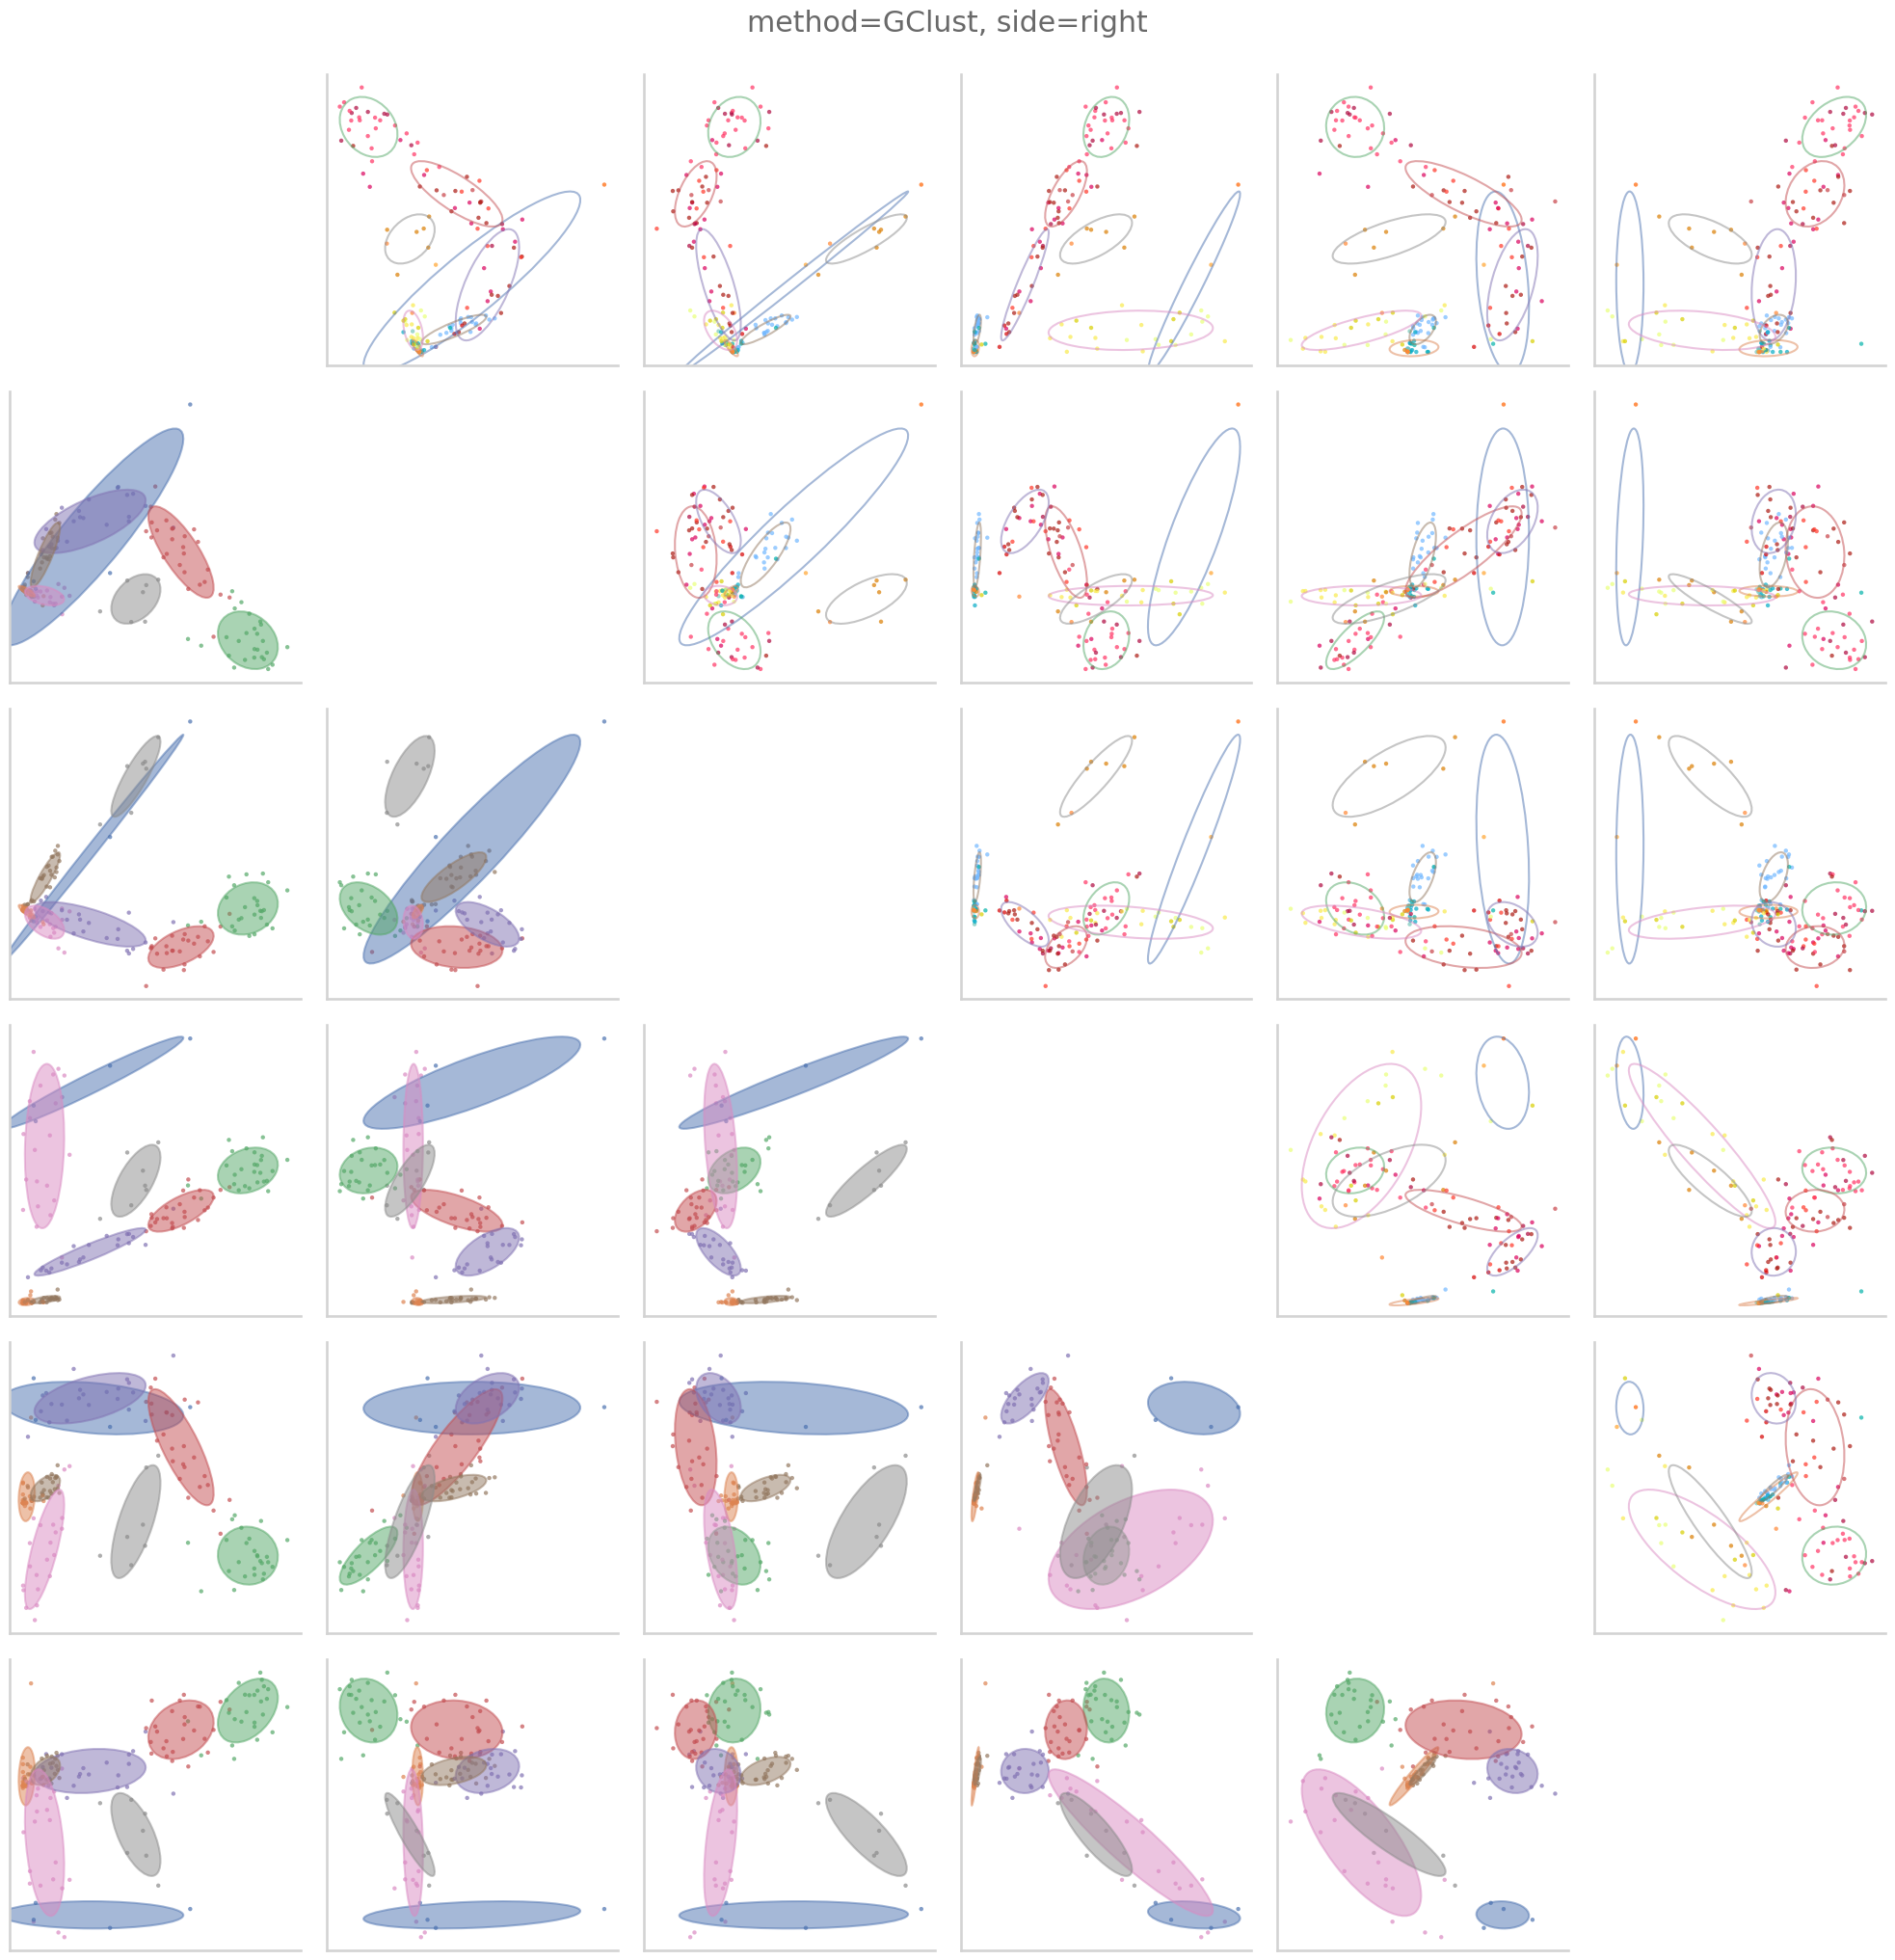

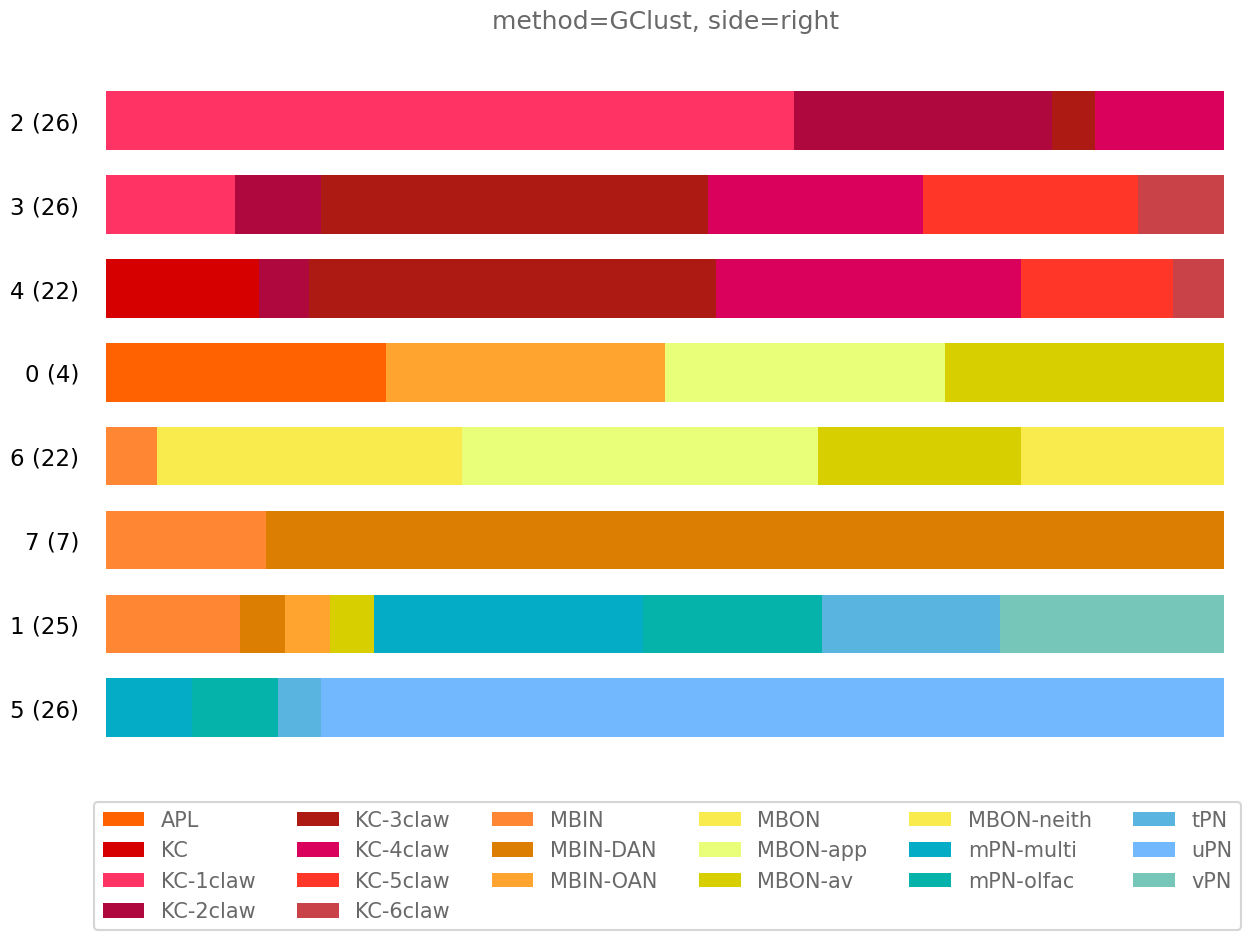

In [6]:

np.random.seed(8888)
side_mgs = {"left": left_mb_mg, "right": right_mb_mg}

cluster_colors = sns.color_palette("deep", 10)
cluster_palette = dict(zip(range(10), cluster_colors))

label_map = {
    "vPN": "PN",
    "tPN": "PN",
    "mPN": "PN",
    "KC": "KC",
    "MBON": "MBON",
    "MBIN": "MBIN",
    "APL": "MBIN",
}

rows = []

for side in ["left", "right"]:
    print(side)
    side_mb_mg = side_mgs[side]
    labels = side_mb_mg.meta["class1"].values
    labels = np.vectorize(label_map.get)(labels)
    plot_labels = side_mb_mg.meta["merge_class"].values

    # embed
    ase = AdjacencySpectralEmbed(n_components=None)
    embed = ase.fit_transform(pass_to_ranks(side_mb_mg.adj))
    embed = np.concatenate(embed, axis=1)

    # cluster using AutoGMM
    method = "AutoGMM"
    agmm = AutoGMMCluster(
        min_components=2,
        max_components=10,
        affinity=["euclidean", "manhattan", "cosine"],
        n_jobs=-1,
    )
    agmm.fit(embed, labels)
    agmm_results = agmm.results_.copy()
    agmm_results.sort_values("bic/aic", inplace=True)
    agmm_model = agmm.model_
    agmm_pred_labels = agmm_model.predict(embed)
    ari = adjusted_rand_score(labels, agmm_pred_labels)
    ari_no_kc = adjusted_rand_score(
        labels[labels != "KC"], agmm_pred_labels[labels != "KC"]
    )
    row = dict(
        ari=ari,
        ari_no_kc=ari_no_kc,
        lik=agmm_model.score(embed),
        bic=agmm_model.bic(embed),
        method="agmm",
        side=side,
        n_components=agmm_model.n_components,
        covariance_type=agmm_model.covariance_type,
    )
    rows.append(row)

    fig, axs = cluster_pairplot(
        embed,
        agmm_model,
        labels=side_mb_mg.meta["merge_class"].values,
        label_palette=CLASS_COLOR_DICT,
        cluster_palette=cluster_palette,
        upper_hue="labels",
        lower_hue="clusters",
        upper_elipses="unfilled",
        lower_elipses="filled",
    )
    fig.suptitle(f"method={method}, side={side}", y=1.02)
    stashfig(f"agmm-cluster-pairplot-side={side}")
    ax = stacked_barplot(agmm_pred_labels, plot_labels, color_dict=CLASS_COLOR_DICT)
    ax.set(title=f"method={method}, side={side}")
    stashfig(f"agmm-barplot-side={side}")

    # cluster using GaussianCluster
    method = "GClust"
    gclust = GaussianCluster(min_components=2, max_components=10, n_init=100)
    gclust.fit(embed)
    gclust_model = gclust.model_
    gclust_results = gclust.bic_.copy()
    gclust_results.index.name = "n_components"
    gclust_results.reset_index(inplace=True)
    gclust_results = pd.melt(
        gclust_results,
        id_vars="n_components",
        var_name="covariance_type",
        value_name="bic/aic",
    )
    gclust_results.sort_values("bic/aic", inplace=True)
    gclust_pred_labels = gclust_model.predict(embed)

    ari = adjusted_rand_score(labels, gclust_pred_labels)
    adjusted_rand_score(labels[labels != "KC"], gclust_pred_labels[labels != "KC"])

    row = dict(
        ari=ari,
        ari_no_kc=ari_no_kc,
        lik=gclust_model.score(embed),
        bic=gclust_model.bic(embed),
        method="gclust",
        side=side,
        n_components=gclust_model.n_components,
        covariance_type=gclust_model.covariance_type,
    )
    rows.append(row)

    fig, axs = cluster_pairplot(
        embed,
        gclust_model,
        labels=side_mb_mg.meta["merge_class"].values,
        label_palette=CLASS_COLOR_DICT,
        cluster_palette=cluster_palette,
        upper_hue="labels",
        lower_hue="clusters",
        upper_elipses="unfilled",
        lower_elipses="filled",
    )
    fig.suptitle(f"method={method}, side={side}", y=1.02)
    stashfig(f"gclust-cluster-pairplot-side={side}")
    ax = stacked_barplot(gclust_pred_labels, plot_labels, color_dict=CLASS_COLOR_DICT)
    ax.set(title=f"method={method}, side={side}")
    stashfig(f"gclust-barplot-side={side}")
    print()

In [7]:
results = pd.DataFrame(rows)
results

ari  ari_no_kc       lik          bic  method   side  n_components  \
0  0.609196   0.714849  7.358873 -1405.711379    agmm   left             7   
1  0.511388   0.714849  7.861299 -1569.502108  gclust   left             7   
2  0.596977   0.600845  7.856741 -1495.524216    agmm  right             7   
3  0.466771   0.600845  8.115179 -1435.437877  gclust  right             8   

  covariance_type  
0            full  
1            full  
2            full  
3            full